In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [171]:
from pprint import pprint
from copy import copy
import time
import warnings
from itertools import cycle, islice
import sys

from astropy.stats import gaussian_sigma_to_fwhm
from astropy.coordinates import SkyCoord, search_around_sky, Angle
from astropy.nddata import Cutout2D
from astropy.table import Table, hstack, vstack, unique
from astropy.wcs import wcs
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy import units as uu
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar, colors
from matplotlib.colors import LogNorm
import matplotlib.markers as mmarkers
import matplotlib.font_manager as fm
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.offsetbox
from matplotlib.lines import Line2D
import numpy as np
from loguru import logger

from uvva.field import BaseField, GALEXField
from uvva.utils import extr_value

In [3]:
# replacing the standard handler
try:
    logger.remove(0)
except ValueError:
    print("[Loguru]: Default handler already removed.")

# setup custom handler to make use of
# additional fields defined by uvva
fmt = (
    "<g>{time:YYYY-MM-DD HH:mm:ss.SSS}</> | "
    "<lvl>{level: ^8}</> | "
    "<c>{name}</>:<c>{line}</> in <c>{extra[classname]}</>:<c>{function}</> | "
    "<lvl>{message}</>"
)
logger.add(sys.stdout, format=fmt, backtrace=False, level="INFO")
# activate logging (is deactivated by import of uvva)
logger.enable("uvva")

In [4]:
"""
list of fields
2552663716076191744 NGS 32 visits
2424979629631602688 MIS 5 visits
2508155485249601536 DIS 5 visits
6388191295067652096 NGC4993-GW170817 2 visits

TDS fields
2605053246158405632 PS_COSMOS_MOS23 DIS 29 visits 
2593653509626789888 PS_CDFS_MOS00 DIS 114 visits 
2594075722091855872 PS_CDFS_MOS06 DIS 29 visits 
2607375414741434368 PS_GROTH_MOS06 DIS 18 visits 
"""

# filed ID
field_id = 6388191295067652096

# initialize field analysis
from_archive = True
from_fits = False

if from_archive:
    gf = GALEXField.from_archive(obs_id=field_id, filter="NUV", refresh=False)
    fits_path = f"{gf.data_path}/{gf.uvva_file_prefix}_field_data.fits"
    gf.write_to_fits(fits_path)
elif from_fits:
    gf = GALEXField.from_fits(obs_id=field_id, filter="NUV")


2022-02-14 10:10:47.149 |   INFO   | uvva.field:306 in GALEXField:add_table | Adding table 'base_field:tt_field'
2022-02-14 10:10:47.251 |   INFO   | uvva.field:306 in GALEXField:add_table | Adding table 'galex_field:tt_visits'
2022-02-14 10:10:50.022 |   INFO   | uvva.field:306 in GALEXField:add_table | Adding table 'galex_field:tt_detections'
2022-02-14 10:10:50.029 |   INFO   | uvva.field:306 in GALEXField:add_table | Adding table 'galex_field:tt_ref_sources'
2022-02-14 10:10:50.033 |   INFO   | uvva.field:286 in GALEXField:load_sky_map | Loading skypmap from file: '/Users/julianschliwinski/Library/Mobile Documents/com~apple~CloudDocs/PhD/ULTRASAT/Science/cloud/uc_science/uvvarcat/GALEX_fields/6388191295067652096/mastDownload/GALEX/6388191295067652096/AIS_491_sg12-nd-int.fits.gz'
2022-02-14 10:10:50.470 |   INFO   | uvva.field:739 in GALEXField:from_archive | Loaded new GALEX field '6388191295067652096' with filter 'NUV' from MAST data.
2022-02-14 10:10:50.471 |   INFO   | uvva.fiel

In [5]:
# Set additional field paramter
r_cluster = (5.0 * uu.arcsec).to(uu.degree).value  # in deg
r_fov = 0.55  # in deg

In [7]:
# Cluster
params = {
    "quantile": 0.01,
    "bandwidth": r_cluster,
    "bin_seeding": True,
    "min_bin_freq": 10,
    "cluster_all": False,
    "n_jobs": -1,
}
gf.cluster_meanshift(params["bandwidth"])

2022-02-14 10:13:22.166 |   INFO   | uvva.field:336 in GALEXField:cluster_meanshift | Clustering sources
2022-02-14 10:13:22.172 |   INFO   | uvva.field:344 in GALEXField:cluster_meanshift | MeanShift with bandwidth '0.001388888888888889'
2022-02-14 10:13:30.872 |   INFO   | uvva.field:305 in GALEXField:add_table | Adding table 'base_field:tt_sources'
2022-02-14 10:13:30.873 | WARNING  | uvva.field:310 in GALEXField:add_table | Table 'tt_sources' already exists, overwriting


6339

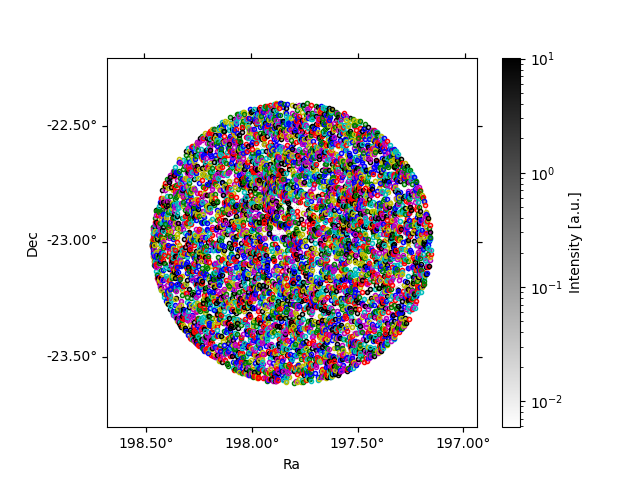

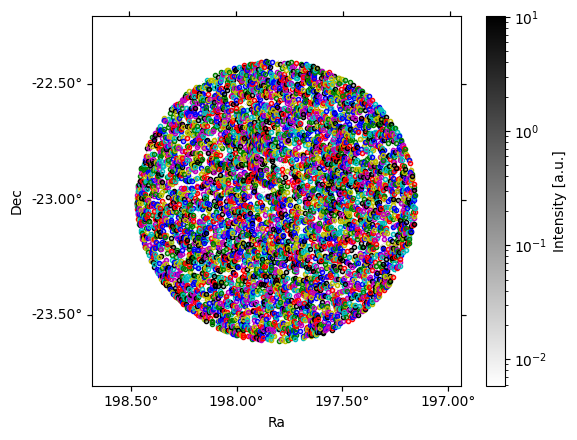

In [24]:
gf.plot_sky(True, True)

In [229]:
# Analysis Functions
# Distance to nearest neighbor    
def get_hist_bins(data, bin_size, is_list=False):
    
    # get minimum and maximum rounded to integer
    if is_list:
        vmin = np.floor(extr_value(data))
        vmax = np.ceil(extr_value(data, upper=True))
    else:
        vmin = np.floor(np.min(data))
        vmax = np.ceil(np.max(data))
    # generate bin array
    bins = np.arange(vmin, vmax, bin_size)
    return bins

# 
def get_sky_bounds(wcs, data_shape, out_frame="fk5"):
    """
    Returns SkyCoord object with coordinates for upperight and lower left
    pixels in coordinate system of 'out_frame'.
    """
    # corner pixels
    # lower left
    x_ll = 0
    y_ll = 0
    # upper right
    x_ur = data_shape[1]
    y_ur = data_shape[0]
    # convert to world coordinates
    ll = cutout.wcs.pixel_to_world(x_ll, y_ll)
    ur = cutout.wcs.pixel_to_world(x_ur, y_ur)
    # separtion
    #print(ll.separation(ur).deg)
          
    return  SkyCoord([ll.ra, ur.ra], [ll.dec, ur.dec], frame=ll.frame).transform_to(out_frame)


def get_cutout_mask(tt_mcat, cutout_bounds, frame="fk5"):
    """
    Returns a bool array to mask a dataset for a given cutout bounds.
    """
    x, y = None, None
    if frame=="icrs" or frame=="fk5":
        x = "ra"
        y = "dec"
        mask_cutout_ra = (tt_mcat[x]<=cutout_bounds[0].ra)  * (tt_mcat[x]>=cutout_bounds[1].ra)
        mask_cutout_dec = (tt_mcat[y]>=cutout_bounds[0].dec)  * (tt_mcat[y]<=cutout_bounds[1].dec)
    elif frame=="galctic":
        x = "lon"
        y = "lat"
        mask_cutout_ra = (tt_mcat[x]<=cutout_bounds[0].l)  * (tt_mcat[x]>=cutout_bounds[1].l)
        mask_cutout_dec = (tt_mcat[y]>=cutout_bounds[0].b)  * (tt_mcat[y]<=cutout_bounds[1].b)
    
    return mask_cutout_ra * mask_cutout_dec

In [199]:
# Plotting functions
def mscatter(x, y, ax=None, m=None, **kw):
    """
    Wrapper for matplotlib.pyplot.scatter() that allows marker to be a list.
    From https://stackoverflow.com/a/52303895/13115938
    """
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

# Scale bar (mpl.AnchoredSizeBar)
def draw_sizebar(ax, length, label, loc="lower right", fontsize=10, frameon=False, label_top=False):
    """
    Draw a horizontal scale bar of given length in data coordinates.
    """
    
    # convert length to pixel scale
    # from: https://aplpy.readthedocs.io/en/stable/_modules/aplpy/overlays.html
    # more info see: https://github.com/astropy/astroplan/issues/383#issuecomment-442518134
    pix_scale = proj_plane_pixel_scales(ax.wcs)
    sx = pix_scale[0]
    sy = pix_scale[1]
    degrees_per_pixel = np.sqrt(sx * sy)
    length = length / degrees_per_pixel
        
    fontprops = fm.FontProperties(size=fontsize)
    asb = AnchoredSizeBar(
        ax.transData,
        length,
        label,
        loc=loc,
        pad=0.1, borderpad=0.8, sep=5,
        frameon=frameon,
        label_top=label_top,
        fontproperties=fontprops,
        color="k",
    )
    ax.add_artist(asb)

# Scale Bar (hack)
def make_scalebar(ax, left_side, length, color='k', linestyle='-', label='',
                  fontsize=12, text_offset=5.0*uu.arcsec):
    axlims = ax.axis()
    lines = ax.plot(
        uu.Quantity([left_side.ra, left_side.ra-length]),
        uu.Quantity([left_side.dec]*2),
        color=color, linestyle=linestyle, marker=None,
        transform=ax.get_transform('world'),
       )
    txt = ax.text(
        (left_side.ra-length/2).to(uu.deg).value,
        (left_side.dec+text_offset).to(uu.deg).value,
        label,
        verticalalignment='bottom',
        horizontalalignment='center',
        transform=ax.get_transform('world'),
        color=color,
        fontsize=fontsize,
    )
    ax.axis(axlims)
    return lines,txt

# Scale Bar (by hand)
# from: https://stackoverflow.com/a/43343934/13115938
class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent=0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linekw={}, **kwargs):
        if not ax:
            ax = plt.gca()
        
        # convert length to pixel scale
        # from: https://aplpy.readthedocs.io/en/stable/_modules/aplpy/overlays.html
        # more info see: https://github.com/astropy/astroplan/issues/383#issuecomment-442518134
        pix_scale = proj_plane_pixel_scales(ax.wcs)
        sx = pix_scale[0]
        sy = pix_scale[1]
        degrees_per_pixel = np.sqrt(sx * sy)
        size = size / degrees_per_pixel
        
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **linekw)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **linekw)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)

range 0.0 113.0
range diff 113
bin size 1
number of bins 113


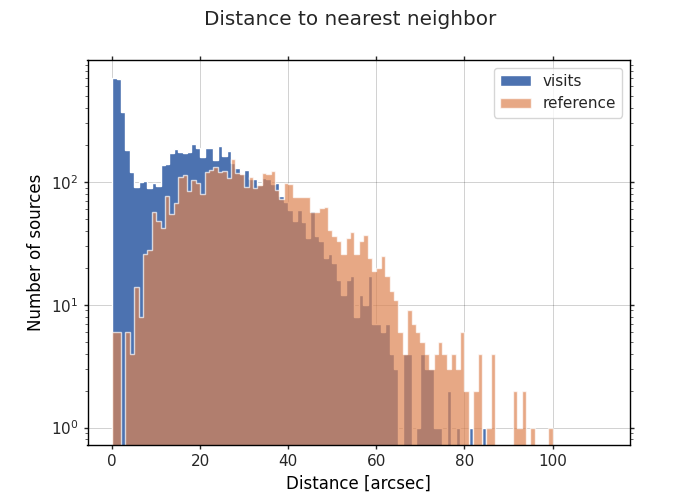

In [26]:
# Plot nearest neighbor distance
pos_visit = SkyCoord(gf.tt_detections["ra"], gf.tt_detections["dec"], frame="icrs")
pos_ref = SkyCoord(gf.tt_ref_sources["ra"], gf.tt_ref_sources["dec"], frame="icrs")
d_nearest_visit = np.asarray(pos_visit.match_to_catalog_sky(pos_visit, nthneighbor=2)[1].to(uu.arcsec).data)
d_nearest_ref= np.asarray(pos_ref.match_to_catalog_sky(pos_ref, nthneighbor=2)[1].to(uu.arcsec).data)

vmin = np.floor(np.min([d_nearest_visit.min(),d_nearest_ref.min()]))
vmax = np.ceil(np.max([d_nearest_visit.max(),d_nearest_ref.max()]))
bin_size = 1

#bins = int((vmax-vmin) * bin_size)
bins = get_hist_bins(data=[d_nearest_visit, d_nearest_ref], bin_size=bin_size, is_list=True)

print("range", vmin, vmax)
print("range diff",int(vmax-vmin))
print("bin size", bin_size)
print("number of bins", len(bins))

fig_num = 0
plt.close(fig_num)
# use custom style sheet
plt.style.use("../mpl_style_sheets/spie_scout_testing.mplstyle")

fig, axs = plt.subplots(num=fig_num, figsize=(7, 5), constrained_layout=False)
fig.suptitle("Distance to nearest neighbor")

axs.hist(d_nearest_visit, bins=bins, log=True, histtype="stepfilled", label="visits")
axs.hist(d_nearest_ref, bins=bins, log=True, histtype="stepfilled", alpha=0.7, label="reference")

axs.set_xlabel("Distance [arcsec]")
axs.set_ylabel("Number of sources")
axs.legend()


In [268]:
# Plot sky map & cutout
def plot_galex_field(gf, show_ref=True, show_sources=True, show_cutout=True, show_fov=True, num=None, **cutout_args):
    # fits image
    ref_int_map = gf.ref_img
    # world coordinates
    wcs = gf.ref_wcs

    # figure
    plt.close(num)
    fig = plt.figure(num=num, figsize=(8.5, 7.2), constrained_layout=False)
    ax = plt.subplot(projection=wcs)

    fig.suptitle(f"{gf.observatory} {gf.name} - {gf.obsfilter}")

    # set color map
    cmap = copy(cm.get_cmap("gist_yarg"))
    #cmap.set_bad([0.08, 0.06, 0.11])
    label_fontsize = 8

    # intensity data (flux [a.u.)
    img = ax.imshow(
        ref_int_map.data,
        cmap=cmap,
        norm=LogNorm(),
        origin="lower",
        interpolation="none",
    )

    # scale bar
    r_cluster_arcsec = (r_cluster*uu.deg).to(uu.arcsec)
    draw_sizebar(ax, r_cluster, f"{r_cluster_arcsec:1.1f}", loc="upper left", fontsize=8, frameon=False, label_top=True)

    # ref. sources & cluster detections
    if show_ref:
        ax.scatter(
            gf.tt_ref_sources["ra"],
            gf.tt_ref_sources["dec"],
            transform=ax.get_transform("world"),
            s=3**2,
            edgecolor="b",
            facecolor="none",
            #lw=0.5,
            marker="s",
            alpha=0.5,
            label="ref",
        )
    if show_sources:
        ax.scatter(
            gf.tt_sources["ra"],
            gf.tt_sources["dec"],
            transform=ax.get_transform("world"),
            s=3**2,
            edgecolor="r",
            facecolor="r",
            #lw=0.5,
            marker="v",
            alpha=0.5,
            label="src",
        )
    
    if show_sources or show_ref:
        ax.legend(fontsize=label_fontsize)
    
    # cutout
    if show_cutout:
        set_cutout = {
            "pos": gf.center,
            "size": uu.Quantity((0.1, 0.1), uu.deg)
        }
        if cutout_args is not None:
            set_cutout.update(cutout_args)

        cutout = get_cutout(data=ref_int_map.data, **set_cutout)
        

    # field of view cut
    if show_fov:
        ax.scatter(center.ra, center.dec, transform=ax.get_transform("world"), c="k", marker="+")
        s = SphericalCircle((center.ra, center.dec), r_fov * uu.deg,
                            edgecolor='k', facecolor='none',
                            transform=ax.get_transform('world'))
        ax.add_patch(s)

    # modify grid
    ax.coords.grid(True, color='k', ls='-')

    # set axis labels
    ra = ax.coords["ra"]
    dec = ax.coords["dec"]
    ra.set_major_formatter("d.dd")
    dec.set_major_formatter("d.dd")

    ax.set_xlabel("Ra", fontsize=label_fontsize)
    ax.set_ylabel("Dec", fontsize=label_fontsize)
    ax.xaxis.set_tick_params(labelsize=label_fontsize)
    ax.yaxis.set_tick_params(labelsize=label_fontsize)
    ax.tick_params(axis="x", labelsize=label_fontsize, bottom=True, top=False)
    ax.tick_params(axis="y", labelsize=label_fontsize, left=True, right=False)

    # secondary grid
    overlay = ax.get_coords_overlay("galactic")
    overlay.grid(color="k", ls="dotted")
    labels = ["Lon", "Lat"]
    ticks_pos = ["t", "r"]
    for i in range(2):
        overlay[i].set_axislabel(labels[i], fontsize=label_fontsize)
        overlay[i].set_ticklabel(color="k", size=label_fontsize)
        overlay[i].set_ticks(color="k", direction="in")
        overlay[i].set_ticks_position(ticks_pos[i])

    # add color bar
    cbaxes = fig.add_axes([0.86, 0.1, 0.03, 0.75])
    cbaxes.grid(False)
    cb = colorbar.Colorbar(
        ax=cbaxes,
        mappable=img,
    )
    cb.ax.tick_params(which="both", labelsize=label_fontsize)
    cb.set_label(f"{gf.obsfilter} intensity [a.u.]", size=label_fontsize)

    # layout
    plt.subplots_adjust(
                left=-0.05, bottom=0.082, right=0.88, top=0.85, wspace=0.2, hspace=0.20
            )
    
    if show_cutout:
        return (fig, cutout)
    else:
        return fig

def get_cutout(data, size, pos, ax=None, color="k", marker="x"):
    
    # get axis
    if ax is None:
        ax = plt.gca()
    # make cutout    
    cutout = Cutout2D(data, pos, size, wcs=ax.wcs)
    # draw cutout box
    cutout.plot_on_original(color=color)
    # draw cutout center coodinate
    ax.scatter(position.ra, position.dec, transform=ax.get_transform("world"), c=color, marker=marker)
    
    return cutout

def plot_cutout(cutout, tt_ref=None, tt_sources=None, cmap="gist_yarg", num=None):
    
    label_fontsize = 8
    
    plt.close(num)
    
    fig = plt.figure(num=num)
    ax = plt.subplot(projection=cutout.wcs)
    
    # set axis
    ra = ax.coords["ra"]
    dec = ax.coords["dec"]
    ra.set_major_formatter("d.dd")
    dec.set_major_formatter("d.dd")
    ax.set_xlabel("Ra", fontsize=label_fontsize)
    ax.set_ylabel("Dec", fontsize=label_fontsize)
    ax.xaxis.set_tick_params(labelsize=label_fontsize)
    ax.yaxis.set_tick_params(labelsize=label_fontsize)
    ax.tick_params(axis="x", labelsize=label_fontsize, bottom=True, top=False)
    ax.tick_params(axis="y", labelsize=label_fontsize, left=True, right=False)
    
    # cutout data
    img = ax.imshow(
        cutout.data,
        cmap=cmap,
        norm=LogNorm(),
        origin="lower",
        interpolation="none",
    )
    #ax.scatter(position.ra, position.dec, transform=ax.get_transform("world"), marker="x", color="k")
    
    # source & reference data
    if tt_ref is not None or tt_sources is not None:
        cutout_bounds = get_sky_bounds(cutout.wcs, cutout.data.shape)
        ax.set_autoscale_on(False)
        
    if tt_sources is not None:
        pos_visit_cutout = tt_sources["ra","dec"][get_cutout_mask(tt_sources, cutout_bounds, frame="fk5")]

        ax.scatter(
            pos_visit_cutout["ra"],
            pos_visit_cutout["dec"],
            transform=ax.get_transform("world"),
            s=3**2,
            #edgecolor=(0,0,0,0.8),
            #facecolor=(0,0,0,0.1),
            #lw=0.5,
            edgecolor="r",
            facecolor="r",
            #alpha=0.2,
            marker="v",
            label="src",
        )
    
    if tt_ref is not None:
        pos_ref_cutout = tt_ref["ra","dec"][get_cutout_mask(tt_ref, cutout_bounds, frame="fk5")]
        ax.scatter(
            pos_ref_cutout["ra"],
            pos_ref_cutout["dec"],
            transform=ax.get_transform("world"),
            s=3**2,
            #edgecolor=(1,0,0,0.8),
            #facecolor=(1,0,0,0.5),
            #lw=0.5,
            edgecolor="b",
            facecolor="none",
            marker="s",
            label="ref",
        )
    ax.legend(fontsize=label_fontsize)
    
    # add color bar
    cbaxes = fig.add_axes([0.76, 0.1, 0.03, 0.65])
    cbaxes.grid(False)
    cb = colorbar.Colorbar(
        ax=cbaxes,
        mappable=img,
        #orientation="vertical",
    )
    cb.ax.tick_params(which="both", labelsize=label_fontsize)
    cb.set_label(f"{gf.obsfilter} intensity [a.u.]", size=label_fontsize)

    # layout
    plt.subplots_adjust(
                left=-0.05, bottom=0.082, right=0.88, top=0.85, wspace=0.2, hspace=0.20
            )
    
    return fig

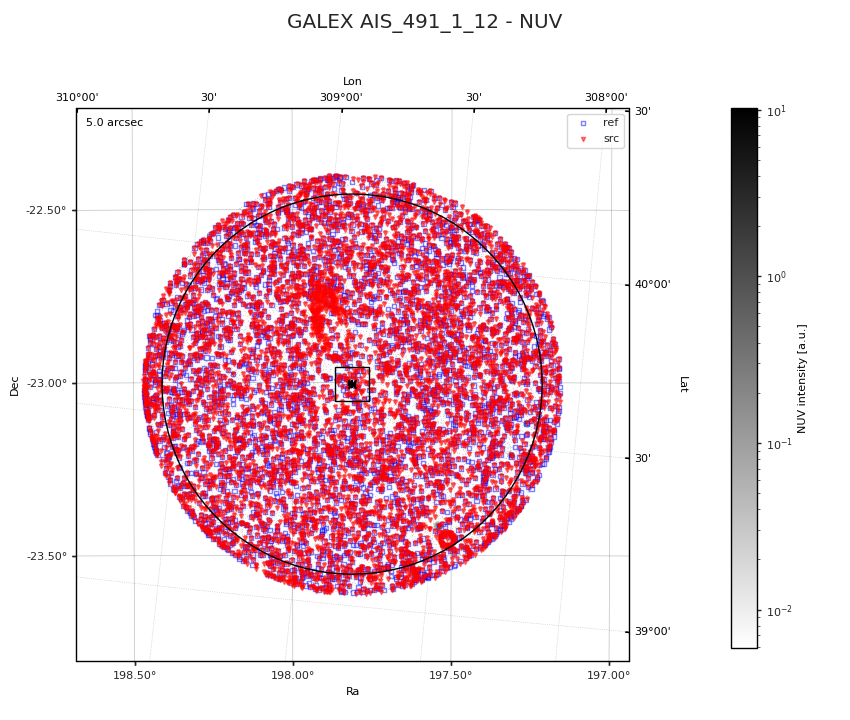

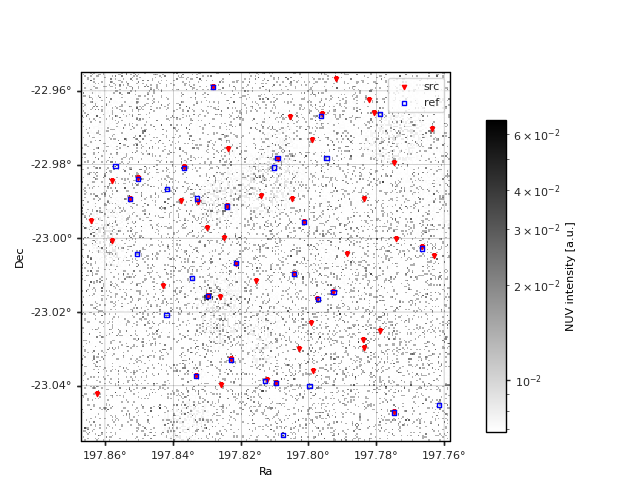

In [269]:
# show sky

# cutout positions
#position = SkyCoord(ra=214.67, dec=52.85, frame="icrs", unit=uu.degree)  # 2607375414741434368 PS_GROTH_MOS06
#position = SkyCoord(ra=151.06, dec=2.235, frame="icrs", unit=uu.degree)  # 2605053246158405632 PS_COSMOS_MOS23 - cutout1 
#position = SkyCoord(ra=150.78, dec=2.3965, frame="icrs", unit=uu.degree)  # 2605053246158405632 PS_COSMOS_MOS23 - cutout2

fig_sky, cutout = plot_galex_field(gf, num=3)
fig_cutout = plot_cutout(cutout, tt_ref=gf.tt_ref_sources["ra","dec"], tt_sources=gf.tt_sources["ra","dec"], num=4)


In [193]:
file_name = "/Users/julianschliwinski/Library/Mobile Documents/com~apple~CloudDocs/PhD/ULTRASAT/Science/cloud/uc_science/uvvarcat/GALEX_fields/6388191295067652096/mastDownload/GALEX/6388191295067652096/AIS_491_sg12-xd-mcat.fits.gz"
file_name = "/Users/julianschliwinski/Library/Mobile Documents/com~apple~CloudDocs/PhD/ULTRASAT/Science/cloud/uc_science/uvvarcat/GALEX_fields/6388191295067652096/UVVA_GALEX_6388191295067652096_NUV_field_data.fits"
with fits.open(file_name) as ff:
            nwcs = wcs.WCS(ff[0].header)
nwcs = gf.ref_wcs
print(nwcs.wcs.cdelt)
pix_scale = proj_plane_pixel_scales(nwcs)
sx = pix_scale[0]
sy = pix_scale[1]
degrees_per_pixel = np.sqrt(sx * sy)
print(degrees_per_pixel)
print((degrees_per_pixel*uu.deg).to(uu.arcsec))
print(np.sqrt(-1*nwcs.wcs.cdelt[0] * nwcs.wcs.cdelt[1]))


[-0.00041667  0.00041667]
0.000416666666666667
1.5000000000000013 arcsec
0.000416666666666667
